In [1]:
import function.functions as functions

from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys

import importlib

plt.rcParams['text.usetex'] = True
params = {
    "backend": "ps",
    "axes.labelsize": 22,
    "font.size": 22,
    "legend.fontsize": 10,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "legend.frameon": True,
    "savefig.dpi": 100,
    "axes.linewidth": 1.5,
    'xtick.major.size' : 10,
    'xtick.major.width': 1,
    'xtick.minor.size': 7,
    'xtick.minor.width': 1,
    'ytick.major.size' : 10,
    'ytick.major.width': 1,
    'ytick.minor.size': 7,
    'ytick.minor.width': 1,
    'axes.xmargin' : 0,
    'axes.ymargin' : 0,
}
plt.rcParams.update(params)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('text', usetex=True)

In [2]:
# Set device and parameters in this part

############################# Set parameters ##############################
device = 'fluxonium' # change here to change the device: charge_qubit, flopping_spin, flopping_charge, transmon, fluxonium

device_module = importlib.import_module('parameters.' + device)
globals().update(vars(device_module)) # import parameters of the device

########################### Parameters of the paper ###########################
if device == 'flopping_spin':
    e0_list0 = np.linspace(0,0.8,num=100)

elif device == 'flopping_charge':
    e0_list0 = np.linspace(0,0.3,num=100)

elif device == 'transmon':
    e0_list0 = np.linspace(0,0.1,num=100)

elif device == 'fluxonium':
    e0_list0 = np.linspace(0,0.35,num=100)
################################################################################

########################### Custom parameters #################################
# test other e0_list0

save_file = True # test mode or save data
################################################################################

In [3]:
def get_color(colorRGBA1, colorRGBA2):
    alpha = 1 - ((1 - colorRGBA1[3]) * (1 - colorRGBA2[3]) / 255)
    red   = (colorRGBA1[0] * (1 - colorRGBA2[3]) + colorRGBA2[0] * colorRGBA2[3]) / 1
    green = (colorRGBA1[1] * (1 - colorRGBA2[3]) + colorRGBA2[1] * colorRGBA2[3]) / 1
    blue  = (colorRGBA1[2] * (1 - colorRGBA2[3]) + colorRGBA2[2] * colorRGBA2[3]) / 1
    return (np.round(red,3), np.round(green,3), np.round(blue,3), np.round(alpha,3))

from matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list(name='rbb',
	colors=['dodgerblue','white','tab:red'])

def colorFromBivariateData1(Z1,Z2,cmap1 = cmap):
    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    cmap_1 = mpl.cm.ScalarMappable(norm=norm, cmap=cmap1)
    cmap_1.set_array([])
    
    Z1_color = np.array(cmap_1.to_rgba(Z1))
    
    Z1_color[3] = np.round(Z1_color[3]*(1-Z2),3)
    
    return Z1_color

from matplotlib.colors import ListedColormap

my_cmap=LinearSegmentedColormap.from_list(name='rbb2',
	colors=['purple','#2ab07f','gold'])

def colorFromBivariateData2(Z1,Z2,cmap2 = my_cmap):    
    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    cmap_2 = mpl.cm.ScalarMappable(norm=norm, cmap=cmap2)
    cmap_2.set_array([])
    
    Z2_color = np.array(cmap_2.to_rgba(Z1))
        
    Z2_color[3] = np.round(Z2_color[3]*Z2,3)
    
    return Z2_color

In [4]:
e0_list = np.concatenate((-np.array(e0_list0[::-1])[:-1],np.array(e0_list0)))

evals, evecs = functions.construct_eigenstates_nofloquet_static_detuning(H_sys, drive_op, e0_list0)
evals = np.concatenate((np.array(evals[::-1])[:-1],np.array(evals)))

evals_analytical = np.zeros((len(e0_list),n_states))

if device == 'transmon':
    for j in range(n_states):
        evals_analytical[:, j] = (-Ejeff + np.sqrt(8*Ejeff*EC)*(j+1/2) - EC/12*(6*j**2 + 6*j + 3))*np.ones(len(e0_list))

if device == 'flopping_spin' or device == 'flopping_charge':
    ref = functions.construct_eigenstates_nofloquet(H_ref, n_states)[1]

    ref_static_notsc_notsf = functions.construct_eigenstates_nofloquet_static_detuning(H_sys_notsc_notsf, drive_op, e0_list0)[0]
    ref_static_notsf = functions.construct_eigenstates_nofloquet_static_detuning(H_sys_notsf, drive_op, e0_list0)[0]

    color_m_old_static = np.zeros((4,len(e0_list0)),dtype=object) # on the row ground/excited state
    neg_color_m_old_static = np.zeros((4,len(e0_list0)),dtype=object) # on the row ground/excited state

    for idx, e0 in enumerate(e0_list0):
        weight, renormalization = functions.compute_weights(0, ref, evecs[idx])
        
        weights_charge = np.real(weight[:,0]+weight[:,1])/renormalization
        weights_spin = np.real(weight[:,0]+weight[:,2])/renormalization

        for i in range(4):
            color_m_old_static[i,idx] = get_color(colorFromBivariateData1(weights_charge[i],\
                                                            weights_spin[i]),\
                                    colorFromBivariateData2(weights_charge[i],weights_spin[i]))
            neg_color_m_old_static[i,idx] = get_color(colorFromBivariateData1(1-weights_charge[i],\
                                                            weights_spin[i]),\
                                    colorFromBivariateData2(1-weights_charge[i],weights_spin[i]))

    color_m_static = np.zeros((4,len(e0_list)),dtype=object) # on the row ground/excited state

    for i in range(4):
        color_m_static[i,:] = np.concatenate((np.array(neg_color_m_old_static[i,::-1])[:-1],np.array(color_m_old_static[i,:])))

    ref_static_notsc_notsf = np.concatenate((np.array(ref_static_notsc_notsf[::-1])[:-1],np.array(ref_static_notsc_notsf)))
    ref_static_notsf = np.concatenate((np.array(ref_static_notsf[::-1])[:-1],np.array(ref_static_notsf)))


Text(0, 0.5, '$\\varepsilon/\\omega_{\\rm q}$')

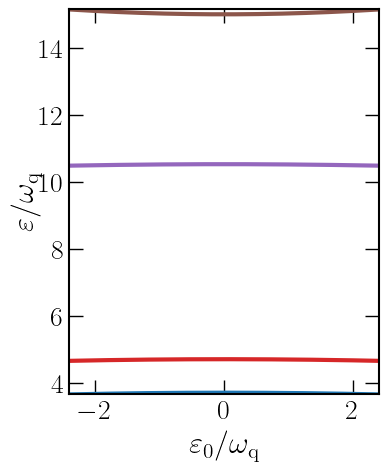

In [5]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(4,5), dpi=100)

cmap = mpl.colormaps["tab10"]
colors = cmap.colors

color_list = [colors[0], colors[3], colors[4], colors[5]]

n_states_show = n_states

for n in range(n_states_show):
    ax.plot(e0_list/wq, evals[:,n]/wq, c=color_list[n], lw=3)
    if device == 'transmon':
        ax.plot(e0_list/wq, evals_analytical[:,n]/wq, ls='--', c=color_list[n], lw=3)

ax.xaxis.set_tick_params(direction="in", which='both')
ax.yaxis.set_tick_params(direction="in", which='both')
ax.tick_params(top=True, bottom=True, left=True, right=True, labelleft=True,
                  labelbottom=True, labelright=False, labeltop=False, which='both')

ax.set_xlabel(r'$\varepsilon_0/\omega_{\rm q}$')
ax.set_ylabel(r'$\varepsilon/\omega_{\rm q}$', labelpad=-2)

In [6]:
if save_file:    
    fname = 'data/'+device+'/'+device+'_static_spectrum_wq='+str(np.round(wq,2))

    if device == 'flopping_spin' or device == 'flopping_charge':
        np.savez(fname, e0_list=e0_list, evals=evals, wq=wq, color_m_static=color_m_static, ref_static_notsf=ref_static_notsf, ref_static_notsc_notsf=ref_static_notsc_notsf)
    
    else:
        np.savez(fname, e0_list=e0_list, evals=evals, wq=wq)